In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers 

In [ ]:
ds = tf.keras.utils.image_dataset_from_directory('sources' ,
                                                 image_size=(256, 256),
                                                 shuffle=True,batch_size=32)
ds

In [ ]:
ds.class_names

In [ ]:
len(ds)

In [ ]:
for image_batch, labels_batch in ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(ds.class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
# train_size = 0.8
# train_size = len(ds)*train_size

In [ ]:
# ds.take(54)

In [ ]:
# test_ds = ds.skip(54)
# len(test_ds)

In [ ]:
# len(ds)-len(test_ds)

In [ ]:
# val_size=0.1
# len(ds)*val_size

In [ ]:
# val_ds = test_ds.take(7)
# test_ds = test_ds.skip(7)

In [ ]:
# len(test_ds) , len(val_ds)

In [ ]:
def train_test(dataset , train_split=0.8 , test_split=0.1 ,val_split=0.1 ,shuffle=True):
    ds_size = len(dataset)
    train_size = int(train_split * ds_size)
    test_size = int(test_split * ds_size)
    
    train_ds = dataset.take(train_size)
    test_ds = dataset.skip(train_size).take(test_size)    
    val_ds = dataset.skip(train_size).skip(test_size)    
    print(f"""
        train_ds : {len(train_ds)}
        test_ds : {len(test_ds)}
        val_ds : {len(val_ds)}
    """)
    return train_ds , test_ds , val_ds


In [ ]:
 train_ds , test_ds , val_ds = train_test(ds)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## Building Model


In [ ]:
IMAGE_SIZE = 256

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE , IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
# Augmentation
flip_and_rotation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
  
])

In [ ]:
class_names = ds.class_names

In [ ]:
input_shape = (32 , 256 ,256 , 3)
n_classes = len(ds.class_names)

model = tf.keras.Sequential([
    resize_and_rescale,
    flip_and_rotation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
]) 
model.build(input_shape=input_shape)
model.summary()

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
# checkpoint_path = "training_1/cp.h5"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_best_only=True,
#                                                  verbose=1 ,
#                                                 )

In [ ]:
model.fit(train_ds, batch_size=64 , epochs=1 ,validation_data=val_ds )
# , callbacks=[cp_callback]

In [ ]:
path = '/Users/macbook/Desktop/HOME/Ai_Projects/Notebooks/potato_disease_problem/trained_model/training_1'
from keras.models import load_model
from keras.losses import SparseCategoricalCrossentropy

# Load the saved model
model = load_model(path , compile=False)

# # Remove the `fn` argument from the loss function
# loss_fn = SparseCategoricalCrossentropy()

# # Compile the model with the loss function
# model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])

In [ ]:
def train_test_split(dataset , train_split=0.8 ,val_split=0.1 ,test_split=0.1):
    ds_size = len(dataset)
    train_size = int(ds_size * train_split)
    val_size = int(val_split * ds_size)

    train_ds  = dataset.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds , val_ds , test_ds


train , test , val = train_test_split(ds)

In [ ]:
predictions = model.predict(test)

In [ ]:
ds.class_names

In [ ]:
for images_batch, labels_batch in test.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",ds.class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",ds.class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    print("predictions ", predictions)
    print('class ' , (np.argmax(predictions[0])))
    predicted_class = ds.class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 115ms/step
predictions  [[2.3155401e-10 5.8888290e-03 9.9411112e-01]]
class  2
1/1 [==============================] - 0s 109ms/step
predictions  [[9.9749666e-01 2.5013909e-03 1.9322263e-06]]
class  0


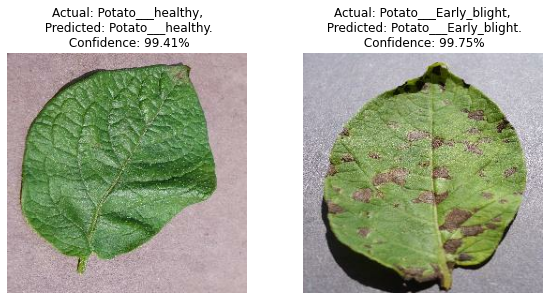

In [87]:

plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(2):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = ds.class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
pred =  [[1.7921918e-03,9.9783945e-01, 3.6831296e-04]]

In [85]:
np.argmax(pred[0])


1

In [88]:
np.max(pred[0])

0.99783945

In [113]:
path = "/Users/macbook/Desktop/HOME/Ai_Projects/Notebooks/potato_disease_problem/trained_model/trained_models"
model.save(path)


INFO:tensorflow:Assets written to: /Users/macbook/Desktop/HOME/Ai_Projects/Notebooks/potato_disease_problem/trained_model/trained_models/assets


INFO:tensorflow:Assets written to: /Users/macbook/Desktop/HOME/Ai_Projects/Notebooks/potato_disease_problem/trained_model/trained_models/assets


In [112]:

img_batch = np.expand_dims(image, 1)
img_batch , img_batch.shape

(array([[12],
        [ 2],
        [ 2]]),
 (3, 1))

In [101]:
image = [12,2,2]

In [114]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [116]:
import json
with open('class_names.json', 'w') as json_file:
    json.dump(class_names, json_file)

In [117]:
  fake_pred = {
            'shape': ((1, 256, 256, 3), (256, 256, 3)),
            'model': "<keras.engine.sequential.Sequential object at 0x16b841360>",
            'prediction': [[7.4639344e-01, 2.5355941e-01, 4.7039121e-05]],
            'classes': ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'],
            'Real Prediction': 'Potato___Early_blight'
        }

In [121]:
m = 100 * np.max(fake_pred['prediction'])

In [122]:
 m

74.639344